In [48]:
import cv2
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50, DenseNet201
import matplotlib.pyplot as plt

In [49]:
os.listdir('../input')

['test', 'sample_submission.csv', 'train.csv', 'train']

In [50]:
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [52]:
batch_size=32
img_size = 32
nb_epochs = 100

In [51]:
train_df['has_cactus'] = train_df['has_cactus'].astype(str)

In [53]:
%%time
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_df,        
        directory = '../input/train/train',
        x_col = 'id', y_col = 'has_cactus',
        target_size=(img_size,img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

Found 13125 images belonging to 2 classes.
CPU times: user 620 ms, sys: 304 ms, total: 924 ms
Wall time: 6.1 s


In [54]:
validation_generator = train_datagen.flow_from_dataframe(
        dataframe = train_df,        
        directory = '../input/train/train',
        x_col = 'id', y_col = 'has_cactus',
        target_size=(img_size,img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

Found 4375 images belonging to 2 classes.


In [55]:
dense_net201 = DenseNet201(include_top=False, 
                  input_shape=(img_size, img_size, 3))

KeyboardInterrupt: 

In [56]:
model = Sequential()
model.add(dense_net201)
model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1, 1, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               491776    
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 514       
Total params: 18,814,274
Trainable params: 18,585,218
Non-trainable params: 229,056
__________________________________________________________

In [57]:
%%time
# Train model
from keras.callbacks import ModelCheckpoint
mcp = ModelCheckpoint(filepath='model_check_path.hdf5',monitor="val_acc", save_best_only=True, save_weights_only=False)
history = model.fit_generator(
            train_generator,
#             steps_per_epoch = train_generator.samples // batch_size,
            steps_per_epoch = 100,
            validation_data = validation_generator, 
#             validation_steps = validation_generator.samples // batch_size,
            validation_steps = 50,
            epochs = 100,
            verbose=2,
            callbacks=[mcp])

Epoch 1/100
 - 113s - loss: 0.1058 - acc: 0.9634 - val_loss: 4.0859 - val_acc: 0.7438
Epoch 2/100
 - 19s - loss: 0.0841 - acc: 0.9691 - val_loss: 0.1754 - val_acc: 0.9537
Epoch 3/100
 - 19s - loss: 0.0730 - acc: 0.9762 - val_loss: 0.1011 - val_acc: 0.9610
Epoch 4/100
 - 19s - loss: 0.0412 - acc: 0.9841 - val_loss: 0.1700 - val_acc: 0.9444
Epoch 5/100
 - 19s - loss: 0.0516 - acc: 0.9819 - val_loss: 0.0733 - val_acc: 0.9756
Epoch 6/100
 - 20s - loss: 0.0401 - acc: 0.9844 - val_loss: 0.0630 - val_acc: 0.9736
Epoch 7/100
 - 19s - loss: 0.0256 - acc: 0.9916 - val_loss: 0.0865 - val_acc: 0.9731
Epoch 8/100
 - 19s - loss: 0.0312 - acc: 0.9887 - val_loss: 0.0967 - val_acc: 0.9681
Epoch 9/100
 - 19s - loss: 0.0585 - acc: 0.9840 - val_loss: 0.0432 - val_acc: 0.9881
Epoch 10/100
 - 19s - loss: 0.0326 - acc: 0.9881 - val_loss: 0.1816 - val_acc: 0.9287
Epoch 11/100
 - 21s - loss: 0.0314 - acc: 0.9903 - val_loss: 0.0730 - val_acc: 0.9717
Epoch 12/100
 - 19s - loss: 0.0228 - acc: 0.9931 - val_loss: 0

Epoch 97/100
 - 18s - loss: 0.0723 - acc: 0.9725 - val_loss: 0.0802 - val_acc: 0.9656
Epoch 98/100
 - 19s - loss: 0.0458 - acc: 0.9847 - val_loss: 0.0602 - val_acc: 0.9806
Epoch 99/100
 - 20s - loss: 0.0464 - acc: 0.9822 - val_loss: 0.0699 - val_acc: 0.9661
Epoch 100/100
 - 19s - loss: 0.0340 - acc: 0.9878 - val_loss: 0.1658 - val_acc: 0.9387
CPU times: user 46min 34s, sys: 3min 47s, total: 50min 22s
Wall time: 34min 6s


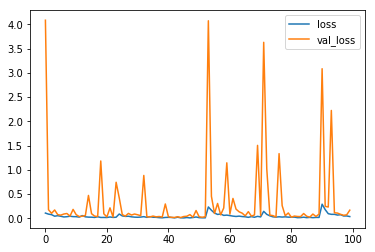

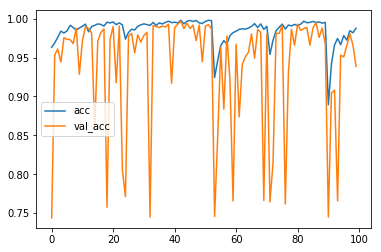

In [58]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [59]:
from glob import glob
import cv2
imagePatches = glob('../input/test/test/*.jpg', recursive=True)
imagePatches[0].split('/')[4].split('.')[0]

'79ac4cc3b082e0a1defe1be601806efd'

In [60]:
from glob import glob
import cv2
imagePatches = glob('../input/test/test/*.jpg', recursive=True)
x=[]
file_id = []
for img in imagePatches:
   
    full_size_image = cv2.imread(img)
    im = cv2.resize(full_size_image, (32, 32), interpolation=cv2.INTER_CUBIC)
    x.append(im)
    file_id.append(img.split('/')[4])

In [61]:
print(len(x))
print(len(file_id))

4000
4000


In [62]:
x = np.array(x)
model.load_weights('model_check_path.hdf5')
y = model.predict(x)


In [63]:
y=np.argmax(y,axis=1)

In [64]:
y

array([1, 0, 0, ..., 1, 0, 1])

In [65]:
sample_sub = pd.read_csv('../input/sample_submission.csv')
sample_sub.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [66]:
sub = pd.DataFrame()
sub['id']=pd.Series(file_id)
sub['has_cactus']=pd.Series(y) 
sub.head()

,id,has_cactus
0,79ac4cc3b082e0a1defe1be601806efd.jpg,1
1,e880364d6521c6f3a27748ec62b0e335.jpg,0
2,74912492b6cdf28c4bfb9c8e1d35af3e.jpg,0
3,078cfa961183b30693ea2f13f5ff6d17.jpg,0
4,7fd729184ef182899ce3e7a174fb9bc0.jpg,0


In [67]:
sub.to_csv('sub.csv',index=False)